# Transformer Model Evaluation

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import unicodedata
import re
import editdistance
import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score

In [17]:
# config
BATCH_SIZE = 64

BASE_DIR = os.path.abspath('..')
DATA_PATH = os.path.join(BASE_DIR, 'data/raw/eng_khm_data.csv')

# Model paths
KHM2ENG_MODEL_PATH = os.path.join(BASE_DIR, 'models/transformer_romanizer.keras')
ENG2KHM_MODEL_PATH = os.path.join(BASE_DIR, 'models/transformer_eng2khm.keras')

# Assets paths
KHM2ENG_ASSETS_PATH = os.path.join(BASE_DIR, 'data/processed/transformer_romanization_assets.pkl')
ENG2KHM_ASSETS_PATH = os.path.join(BASE_DIR, 'data/processed/transformer_eng2khm_assets.pkl')

# Results paths
KHM2ENG_RESULTS_PATH = os.path.join(BASE_DIR, 'results/khm2eng/')
ENG2KHM_RESULTS_PATH = os.path.join(BASE_DIR, 'results/eng2khm/')

os.makedirs(KHM2ENG_RESULTS_PATH, exist_ok=True)
os.makedirs(ENG2KHM_RESULTS_PATH, exist_ok=True)

In [18]:
df = pd.read_csv(DATA_PATH)
dataset = []

for _, row in df.iterrows():
    normalized_khm = re.sub(r"[^\u1780-\u17FF]", "", row['khm'])
    normalized_khm = unicodedata.normalize('NFC', normalized_khm)
    normalized_eng = re.sub(r"[^a-z]", "", row['eng'].lower())
    dataset.append((normalized_eng, normalized_khm))

# Use 10% for testing
test_size = int(len(dataset) * 0.1)
test_dataset = dataset[-test_size:]

print(f"Total dataset size: {len(dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Sample: {test_dataset[0]}")

Total dataset size: 28576
Test dataset size: 2857
Sample: ('kroyov', 'ក្រយៅ')


## Khmer to English Transformer Evaluation

In [19]:
print("Loading Khmer to English transformer model and assets...")

with open(KHM2ENG_ASSETS_PATH, 'rb') as f:
    khm2eng_assets = pickle.load(f)

khm2eng_khm_tokenizer = khm2eng_assets['khm_tokenizer']
khm2eng_eng_tokenizer = khm2eng_assets['eng_tokenizer']
khm2eng_max_khm_len = khm2eng_assets['max_khm_len']
khm2eng_max_eng_len = khm2eng_assets['max_eng_len']

khm2eng_model = load_model(KHM2ENG_MODEL_PATH)

print(f"Khmer vocab size: {len(khm2eng_khm_tokenizer.word_index)}")
print(f"English vocab size: {len(khm2eng_eng_tokenizer.word_index)}")
print(f"Max Khmer length: {khm2eng_max_khm_len}")
print(f"Max English length: {khm2eng_max_eng_len}")
print("Model loaded successfully!")

Loading Khmer to English transformer model and assets...
Khmer vocab size: 78
English vocab size: 29
Max Khmer length: 24
Max English length: 25
Model loaded successfully!


In [20]:
def romanize_batch_transformer(khmer_texts):
    """
    Batch Khmer to English romanization using transformer model.
    
    Args:
        khmer_texts: List of Khmer text strings
        
    Returns:
        List of romanized English texts
    """
    # Preprocess batch
    processed_texts = []
    for text in khmer_texts:
        text = str(text).strip()
        text = re.sub(r"[^\u1780-\u17FF]", "", text)
        text = unicodedata.normalize('NFC', text)
        processed_texts.append(text if text else " ")
    
    # Encode all texts
    khm_seqs = khm2eng_khm_tokenizer.texts_to_sequences(processed_texts)
    encoder_inputs = pad_sequences(khm_seqs, maxlen=khm2eng_max_khm_len, padding='post')
    
    batch_size = len(khmer_texts)
    
    # Initialize decoder inputs with start token
    decoder_inputs = np.zeros((batch_size, khm2eng_max_eng_len + 1), dtype=np.int32)
    decoder_inputs[:, 0] = khm2eng_eng_tokenizer.word_index['\t']
    
    # Track decoded results
    decoded_results = [[] for _ in range(batch_size)]
    active_samples = list(range(batch_size))
    
    # Decode step by step
    for step in range(khm2eng_max_eng_len):
        if not active_samples:
            break
        
        # Predict for all samples (including finished ones)
        predictions = khm2eng_model.predict(
            [encoder_inputs, decoder_inputs], 
            verbose=0
        )
        
        # Process predictions
        newly_finished = []
        for sample_idx in active_samples:
            char_index = np.argmax(predictions[sample_idx, step, :])
            char = khm2eng_eng_tokenizer.index_word.get(char_index, '')
            
            if char == '\n' or char_index == 0:
                newly_finished.append(sample_idx)
            elif char not in ['\t', '<unk>']:
                decoded_results[sample_idx].append(char)
                
            # Update decoder input for next position
            if step + 1 < khm2eng_max_eng_len + 1:
                decoder_inputs[sample_idx, step + 1] = char_index
        
        # Remove finished samples
        active_samples = [idx for idx in active_samples if idx not in newly_finished]
    
    # Join results
    return [''.join(chars) for chars in decoded_results]

print("Batch inference function defined.")

Batch inference function defined.


In [21]:
print(f"Running Khmer to English batch predictions with batch size {BATCH_SIZE}...")
khm2eng_results_data = []

for batch_start in range(0, len(test_dataset), BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, len(test_dataset))
    batch = test_dataset[batch_start:batch_end]
    
    if batch_start % (BATCH_SIZE * 10) == 0:
        print(f"Processing {batch_start}/{len(test_dataset)}...")
    
    # Extract inputs and targets
    khm_inputs = [item[1] for item in batch] 
    eng_targets = [item[0] for item in batch]
    
    # Batch prediction
    eng_preds = romanize_batch_transformer(khm_inputs)
    
    # Calculate metrics for each sample in batch
    for khm, eng_target, eng_pred in zip(khm_inputs, eng_targets, eng_preds):
        # Calculate metrics
        is_exact_match = 1 if eng_pred == eng_target else 0
        
        # Character-level accuracy using edit distance
        dist = editdistance.eval(eng_pred, eng_target)
        max_len = max(len(eng_pred), len(eng_target))
        char_acc = 1 - (dist / max_len) if max_len > 0 else 1.0
        
        # CER
        cer = dist / len(eng_target) if len(eng_target) > 0 else 0.0
        
        # Character-level F1
        pred_chars = list(eng_pred)
        target_chars = list(eng_target)
        
        common_chars = 0
        if len(pred_chars) > 0 and len(target_chars) > 0:
            pred_counter = pd.Series(pred_chars).value_counts()
            target_counter = pd.Series(target_chars).value_counts()
            
            for char, count in pred_counter.items():
                if char in target_counter:
                    common_chars += min(count, target_counter[char])
        
        precision = common_chars / len(pred_chars) if len(pred_chars) > 0 else 0
        recall = common_chars / len(target_chars) if len(target_chars) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        khm2eng_results_data.append({
            'Input_Khmer': khm,
            'Target_English': eng_target,
            'Predicted_English': eng_pred,
            'Word_Acc': is_exact_match,
            'Char_Acc': char_acc,
            'F1': f1,
            'CER': cer
        })

print("Khmer to English evaluation complete!")

Running Khmer to English batch predictions with batch size 64...
Processing 0/2857...
Processing 640/2857...
Processing 1280/2857...
Processing 1920/2857...
Processing 2560/2857...
Khmer to English evaluation complete!


In [22]:
khm2eng_results_df = pd.DataFrame(khm2eng_results_data)

khm2eng_avg_word_acc = khm2eng_results_df['Word_Acc'].mean()
khm2eng_avg_char_acc = khm2eng_results_df['Char_Acc'].mean()
khm2eng_avg_f1 = khm2eng_results_df['F1'].mean()
khm2eng_avg_cer = khm2eng_results_df['CER'].mean()

print("\n" + "="*60)
print("KHMER TO ENGLISH TRANSFORMER EVALUATION RESULTS")
print("="*60)
print(f"Word-Level Accuracy:      {khm2eng_avg_word_acc:.4f}")
print(f"Character-Level Accuracy: {khm2eng_avg_char_acc:.4f}")
print(f"Average Character F1:     {khm2eng_avg_f1:.4f}")
print(f"Average CER:              {khm2eng_avg_cer:.4f}")
print("="*60)

# Save results
khm2eng_csv_path = os.path.join(KHM2ENG_RESULTS_PATH, 'transformer_khm2eng_evaluation.csv')
khm2eng_results_df.to_csv(khm2eng_csv_path, index=False)
print(f"\nDetailed results saved to: {khm2eng_csv_path}")

# Sample predictions
print("\n" + "="*60)
print("SAMPLE PREDICTIONS (First 10)")
print("="*60)
print(khm2eng_results_df[['Input_Khmer', 'Target_English', 'Predicted_English', 'Word_Acc']].head(10).to_string(index=False))


KHMER TO ENGLISH TRANSFORMER EVALUATION RESULTS
Word-Level Accuracy:      0.0403
Character-Level Accuracy: 0.3201
Average Character F1:     0.4512
Average CER:              1.6658

Detailed results saved to: /teamspace/studios/this_studio/khm_romanization/results/khm2eng/transformer_khm2eng_evaluation.csv

SAMPLE PREDICTIONS (First 10)
 Input_Khmer    Target_English         Predicted_English  Word_Acc
       ក្រយៅ            kroyov                      krov         0
        រ៉ែៗ              reae reaeaeaeaeaeaeaeaeaeaeaea         0
      ព្យាធិ           pyeathi                       pea         0
        បំពម            bampom bampompompompompompompomp         0
      ប្រយូរ            brayur brourourourourourourourou         0
      ប្រសប់            brosob                         b         0
       ឥណ្ឌា             india                      inda         0
      កុមារី           komarey meameameameameameameameam         0
        ធ្មា             thmea                         m  

## English to Khmer Transformer Evaluation

In [23]:
print("Loading English to Khmer transformer model and assets...")

with open(ENG2KHM_ASSETS_PATH, 'rb') as f:
    eng2khm_assets = pickle.load(f)

eng2khm_eng_tokenizer = eng2khm_assets['eng_tokenizer']
eng2khm_khm_tokenizer = eng2khm_assets['khm_tokenizer']
eng2khm_max_eng_len = eng2khm_assets['max_eng_len']
eng2khm_max_khm_len = eng2khm_assets['max_khm_len']

eng2khm_model = load_model(ENG2KHM_MODEL_PATH)

print(f"English vocab size: {len(eng2khm_eng_tokenizer.word_index)}")
print(f"Khmer vocab size: {len(eng2khm_khm_tokenizer.word_index)}")
print(f"Max English length: {eng2khm_max_eng_len}")
print(f"Max Khmer length: {eng2khm_max_khm_len}")
print("Model loaded successfully!")

Loading English to Khmer transformer model and assets...
English vocab size: 27
Khmer vocab size: 80
Max English length: 25
Max Khmer length: 24
Model loaded successfully!


In [24]:
def transliterate_batch_transformer(english_texts):
    """
    Batch English to Khmer transliteration using transformer model.
    
    Args:
        english_texts: List of English text strings
        
    Returns:
        List of transliterated Khmer texts
    """
    # Preprocess batch
    processed_texts = []
    for text in english_texts:
        text = str(text).strip()
        text = re.sub(r"[^a-z]", "", text.lower())
        processed_texts.append(text if text else " ")
    
    # Encode all texts
    eng_seqs = eng2khm_eng_tokenizer.texts_to_sequences(processed_texts)
    encoder_inputs = pad_sequences(eng_seqs, maxlen=eng2khm_max_eng_len, padding='post')
    
    batch_size = len(english_texts)
    
    # Initialize decoder inputs with start token
    decoder_inputs = np.zeros((batch_size, eng2khm_max_khm_len + 1), dtype=np.int32)
    decoder_inputs[:, 0] = eng2khm_khm_tokenizer.word_index['\t']
    
    # Track decoded results
    decoded_results = [[] for _ in range(batch_size)]
    active_samples = list(range(batch_size))
    
    # Decode step by step
    for step in range(eng2khm_max_khm_len):
        if not active_samples:
            break
        
        # Predict for all samples
        predictions = eng2khm_model.predict(
            [encoder_inputs, decoder_inputs], 
            verbose=0
        )
        
        # Process predictions
        newly_finished = []
        for sample_idx in active_samples:
            char_index = np.argmax(predictions[sample_idx, step, :])
            char = eng2khm_khm_tokenizer.index_word.get(char_index, '')
            
            if char == '\n' or char_index == 0:
                newly_finished.append(sample_idx)
            elif char not in ['\t', '<unk>']:
                decoded_results[sample_idx].append(char)
                
            # Update decoder input for next position
            if step + 1 < eng2khm_max_khm_len + 1:
                decoder_inputs[sample_idx, step + 1] = char_index
        
        # Remove finished samples
        active_samples = [idx for idx in active_samples if idx not in newly_finished]
    
    # Join results and normalize
    return [unicodedata.normalize('NFC', ''.join(chars)) for chars in decoded_results]

print("Batch inference function defined.")

Batch inference function defined.


In [25]:
print(f"Running English to Khmer batch predictions with batch size {BATCH_SIZE}...")
eng2khm_results_data = []

for batch_start in range(0, len(test_dataset), BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, len(test_dataset))
    batch = test_dataset[batch_start:batch_end]
    
    if batch_start % (BATCH_SIZE * 10) == 0:
        print(f"Processing {batch_start}/{len(test_dataset)}...")
    
    # Extract inputs and targets
    eng_inputs = [item[0] for item in batch]  
    khm_targets = [item[1] for item in batch] 
    
    # Batch prediction
    khm_preds = transliterate_batch_transformer(eng_inputs)
    
    # Calculate metrics for each sample in batch
    for eng, khm_target, khm_pred in zip(eng_inputs, khm_targets, khm_preds):
        # Calculate metrics
        is_exact_match = 1 if khm_pred == khm_target else 0
        
        # Character-level accuracy using edit distance
        dist = editdistance.eval(khm_pred, khm_target)
        max_len = max(len(khm_pred), len(khm_target))
        char_acc = 1 - (dist / max_len) if max_len > 0 else 1.0
        
        # CER
        cer = dist / len(khm_target) if len(khm_target) > 0 else 0.0
        
        # Character-level F1
        pred_chars = list(khm_pred)
        target_chars = list(khm_target)
        
        common_chars = 0
        if len(pred_chars) > 0 and len(target_chars) > 0:
            pred_counter = pd.Series(pred_chars).value_counts()
            target_counter = pd.Series(target_chars).value_counts()
            
            for char, count in pred_counter.items():
                if char in target_counter:
                    common_chars += min(count, target_counter[char])
        
        precision = common_chars / len(pred_chars) if len(pred_chars) > 0 else 0
        recall = common_chars / len(target_chars) if len(target_chars) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        eng2khm_results_data.append({
            'Input_English': eng,
            'Target_Khmer': khm_target,
            'Predicted_Khmer': khm_pred,
            'Word_Acc': is_exact_match,
            'Char_Acc': char_acc,
            'F1': f1,
            'CER': cer
        })

print("English to Khmer evaluation complete!")

Running English to Khmer batch predictions with batch size 64...
Processing 0/2857...


Processing 640/2857...
Processing 1280/2857...
Processing 1920/2857...
Processing 2560/2857...
English to Khmer evaluation complete!


In [26]:
eng2khm_results_df = pd.DataFrame(eng2khm_results_data)

eng2khm_avg_word_acc = eng2khm_results_df['Word_Acc'].mean()
eng2khm_avg_char_acc = eng2khm_results_df['Char_Acc'].mean()
eng2khm_avg_f1 = eng2khm_results_df['F1'].mean()
eng2khm_avg_cer = eng2khm_results_df['CER'].mean()

print("\n" + "="*60)
print("ENGLISH TO KHMER TRANSFORMER EVALUATION RESULTS")
print("="*60)
print(f"Word-Level Accuracy:      {eng2khm_avg_word_acc:.4f}")
print(f"Character-Level Accuracy: {eng2khm_avg_char_acc:.4f}")
print(f"Average Character F1:     {eng2khm_avg_f1:.4f}")
print(f"Average CER:              {eng2khm_avg_cer:.4f}")
print("="*60)

# Save results
eng2khm_csv_path = os.path.join(ENG2KHM_RESULTS_PATH, 'transformer_eng2khm_evaluation.csv')
eng2khm_results_df.to_csv(eng2khm_csv_path, index=False)
print(f"\nDetailed results saved to: {eng2khm_csv_path}")

# Sample predictions
print("\n" + "="*60)
print("SAMPLE PREDICTIONS (First 10)")
print("="*60)
print(eng2khm_results_df[['Input_English', 'Target_Khmer', 'Predicted_Khmer', 'Word_Acc']].head(10).to_string(index=False))


ENGLISH TO KHMER TRANSFORMER EVALUATION RESULTS
Word-Level Accuracy:      0.0252
Character-Level Accuracy: 0.2728
Average Character F1:     0.3948
Average CER:              1.7583

Detailed results saved to: /teamspace/studios/this_studio/khm_romanization/results/eng2khm/transformer_eng2khm_evaluation.csv

SAMPLE PREDICTIONS (First 10)
    Input_English Target_Khmer          Predicted_Khmer  Word_Acc
           kroyov        ក្រយៅ                      ករវ         0
             reae         រ៉ែៗ                       រែ         0
          pyeathi       ព្យាធិ                     ពិតី         0
           bampom         បំពម បំបំបំបំបំបំបំបំបំបំបំបំ         0
           brayur       ប្រយូរ                     ប្រយ         0
           brosob       ប្រសប់ ប្រប្រប្រប្រប្រប្រប្រប្រ         0
            india        ឥណ្ឌា                    ឥណ្ដៃ         0
          komarey       កុមារី                   ក្រមាយ         0
            thmea         ធ្មា                      ហេត         0
b

## Visualizations

### Khmer to English Visualizations

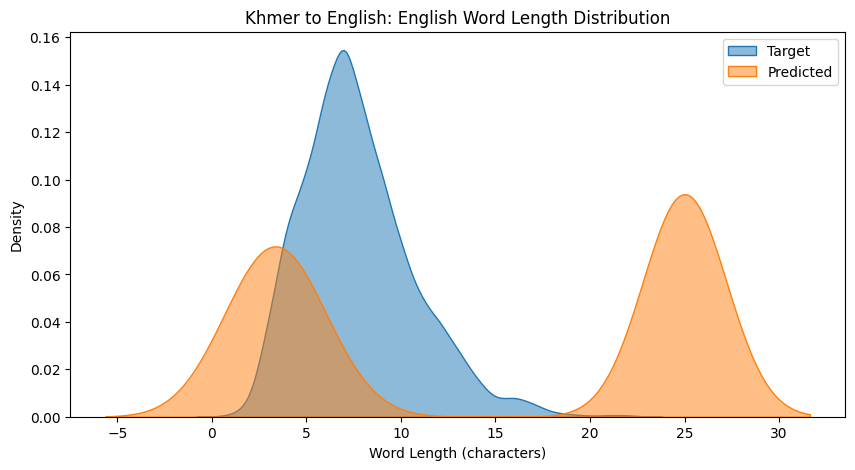

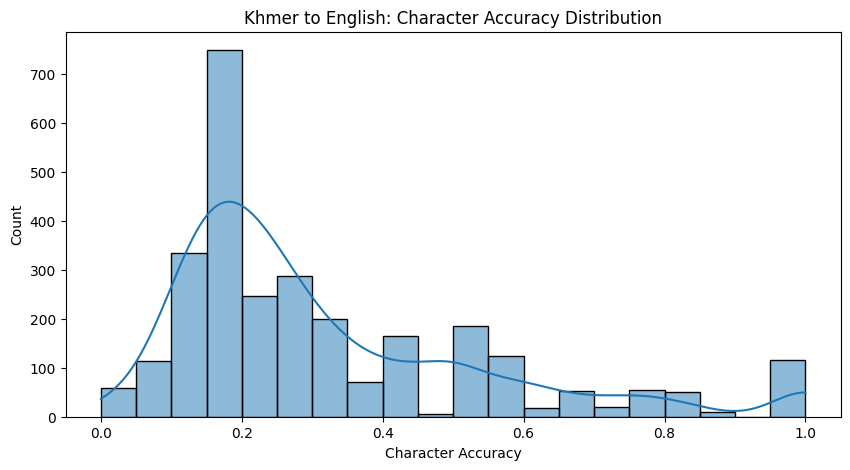

In [27]:
# Word length distribution for Khmer to English
plt.figure(figsize=(10, 5))
target_lengths = [len(word) for word in khm2eng_results_df['Target_English']]
pred_lengths = [len(word) for word in khm2eng_results_df['Predicted_English']]

sns.kdeplot(target_lengths, fill=True, label='Target', alpha=0.5)
sns.kdeplot(pred_lengths, fill=True, label='Predicted', alpha=0.5)
plt.title("Khmer to English: English Word Length Distribution")
plt.xlabel("Word Length (characters)")
plt.ylabel("Density")
plt.legend()
plt.savefig(os.path.join(KHM2ENG_RESULTS_PATH, "transformer_word_length_density.png"))
plt.show()

# Accuracy distribution for Khmer to English
plt.figure(figsize=(10, 5))
sns.histplot(khm2eng_results_df['Char_Acc'], bins=20, kde=True)
plt.title("Khmer to English: Character Accuracy Distribution")
plt.xlabel("Character Accuracy")
plt.ylabel("Count")
plt.savefig(os.path.join(KHM2ENG_RESULTS_PATH, "transformer_accuracy_distribution.png"))
plt.show()

### English to Khmer Visualizations

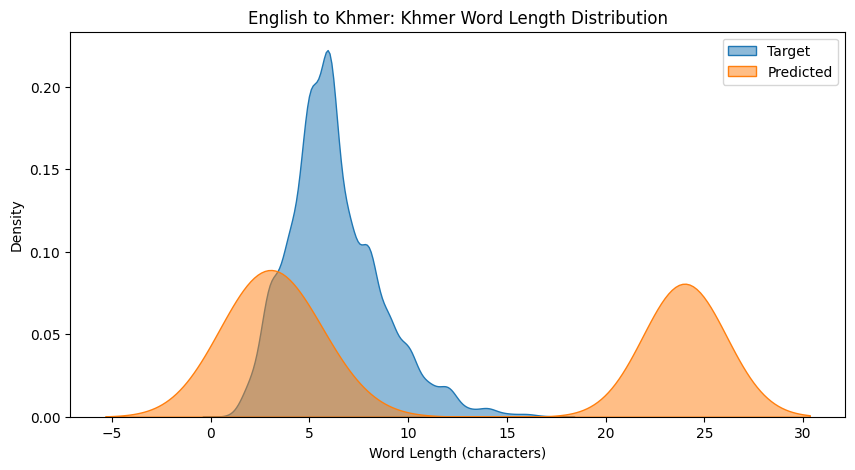

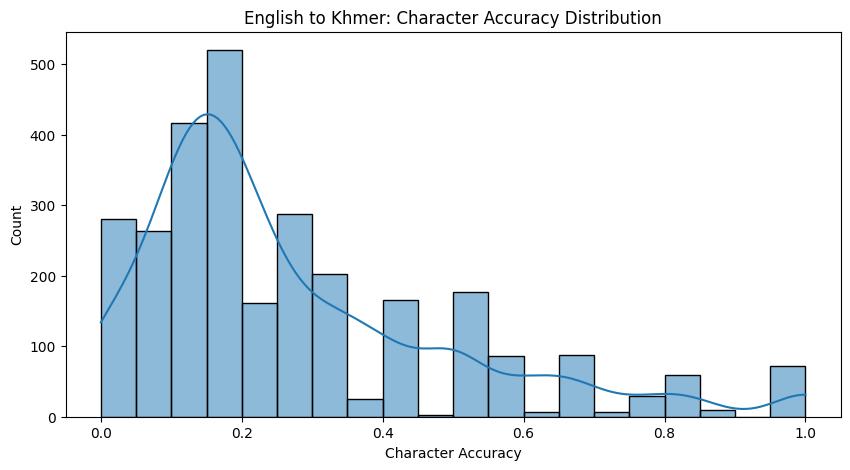

In [28]:
# Word length distribution for English to Khmer
plt.figure(figsize=(10, 5))
target_lengths = [len(word) for word in eng2khm_results_df['Target_Khmer']]
pred_lengths = [len(word) for word in eng2khm_results_df['Predicted_Khmer']]

sns.kdeplot(target_lengths, fill=True, label='Target', alpha=0.5)
sns.kdeplot(pred_lengths, fill=True, label='Predicted', alpha=0.5)
plt.title("English to Khmer: Khmer Word Length Distribution")
plt.xlabel("Word Length (characters)")
plt.ylabel("Density")
plt.legend()
plt.savefig(os.path.join(ENG2KHM_RESULTS_PATH, "transformer_word_length_density.png"))
plt.show()

# Accuracy distribution for English to Khmer
plt.figure(figsize=(10, 5))
sns.histplot(eng2khm_results_df['Char_Acc'], bins=20, kde=True)
plt.title("English to Khmer: Character Accuracy Distribution")
plt.xlabel("Character Accuracy")
plt.ylabel("Count")
plt.savefig(os.path.join(ENG2KHM_RESULTS_PATH, "transformer_accuracy_distribution.png"))
plt.show()

### Comparison of Both Models


TRANSFORMER MODELS COMPARISON
           Model  Word Accuracy  Character Accuracy  F1 Score      CER
Khmer to English       0.040252            0.320118  0.451222 1.665844
English to Khmer       0.025201            0.272793  0.394849 1.758251


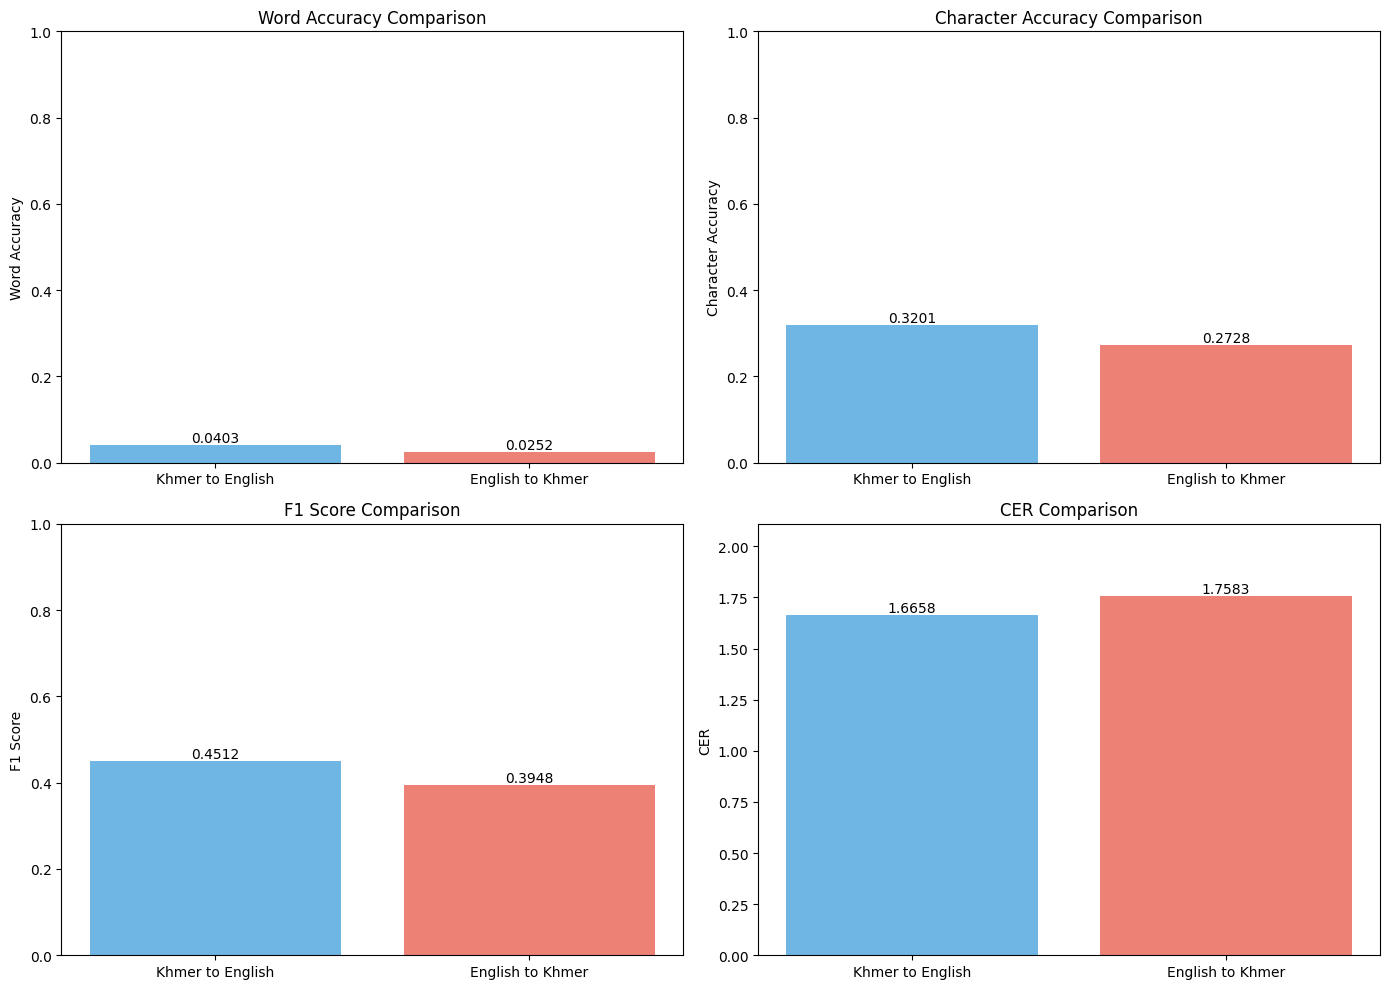


Transformer evaluation complete!


In [29]:
# Create a comparison dataframe
comparison_data = {
    'Model': ['Khmer to English', 'English to Khmer'],
    'Word Accuracy': [khm2eng_avg_word_acc, eng2khm_avg_word_acc],
    'Character Accuracy': [khm2eng_avg_char_acc, eng2khm_avg_char_acc],
    'F1 Score': [khm2eng_avg_f1, eng2khm_avg_f1],
    'CER': [khm2eng_avg_cer, eng2khm_avg_cer]
}
comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*70)
print("TRANSFORMER MODELS COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Bar plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Word Accuracy', 'Character Accuracy', 'F1 Score', 'CER']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], 
                   color=['#3498db', '#e74c3c'], alpha=0.7)
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylim(0, 1 if metric != 'CER' else max(comparison_df['CER']) * 1.2)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'results/transformer_models_comparison.png'))
plt.show()

print("\nTransformer evaluation complete!")